In [2]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 55.8 MB/s eta 0:00:00


In [51]:
import fitz
doc = fitz.open("serverless-core.pdf")
pages = [page.get_text() for page in doc]
full_text = "\n".join(pages)

In [52]:
print(full_text[:1000])

Developer Guide
Serverless
Copyright © 2025 Amazon Web Services, Inc. and/or its aﬃliates. All rights reserved.

Serverless
Developer Guide
Serverless: Developer Guide
Copyright © 2025 Amazon Web Services, Inc. and/or its aﬃliates. All rights reserved.
Amazon's trademarks and trade dress may not be used in connection with any product or service 
that is not Amazon's, in any manner that is likely to cause confusion among customers, or in any 
manner that disparages or discredits Amazon. All other trademarks not owned by Amazon are 
the property of their respective owners, who may or may not be aﬃliated with, connected to, or 
sponsored by Amazon.

Serverless
Developer Guide
Table of Contents
What is serverless development? ................................................................................................... 1
Serverless data processing .............................................................................................................. 4
Asynchronous processing ..

In [53]:
words = full_text.split()
total_words = len(words)
print(f"Total number of words in the PDF: {total_words}")

Total number of words in the PDF: 17935


In [54]:
num_pages = doc.page_count
print(f"Total number of pages in the PDF: {num_pages}")

Total number of pages in the PDF: 91


In [55]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.create_documents([full_text])

In [56]:
print(f"Total chunks created: {len(chunks)}")
lengths = [len(chunk.page_content) for chunk in chunks]
print(lengths)

Total chunks created: 175
[653, 947, 902, 884, 865, 893, 879, 560, 925, 925, 919, 918, 909, 295, 919, 591, 994, 655, 959, 967, 932, 900, 932, 948, 993, 663, 960, 984, 921, 986, 932, 987, 756, 955, 936, 311, 987, 861, 979, 526, 936, 528, 955, 321, 997, 980, 324, 986, 716, 940, 601, 959, 923, 320, 920, 477, 996, 192, 856, 926, 574, 938, 278, 936, 410, 982, 985, 691, 735, 284, 806, 975, 776, 984, 977, 473, 958, 985, 272, 622, 940, 645, 998, 707, 965, 842, 931, 992, 954, 213, 990, 698, 225, 919, 945, 794, 990, 964, 262, 907, 832, 738, 985, 465, 459, 977, 943, 542, 958, 643, 949, 929, 996, 338, 963, 721, 985, 720, 976, 509, 941, 952, 281, 927, 634, 976, 459, 835, 959, 785, 989, 166, 933, 514, 921, 402, 917, 783, 925, 750, 987, 908, 494, 945, 808, 916, 936, 836, 741, 598, 738, 967, 902, 721, 905, 398, 989, 910, 856, 992, 929, 427, 978, 349, 978, 636, 995, 992, 474, 988, 871, 903, 718, 834, 589]


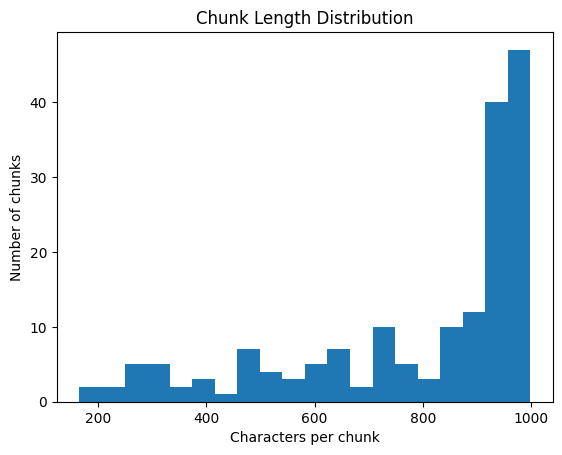

In [57]:
import matplotlib.pyplot as plt
plt.hist(lengths, bins=20)
plt.title("Chunk Length Distribution")
plt.xlabel("Characters per chunk")
plt.ylabel("Number of chunks")
plt.show()

In [58]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode([doc.page_content for doc in chunks])

In [14]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 29.2 MB/s eta 0:00:00


In [59]:
import faiss
import numpy as np
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings))

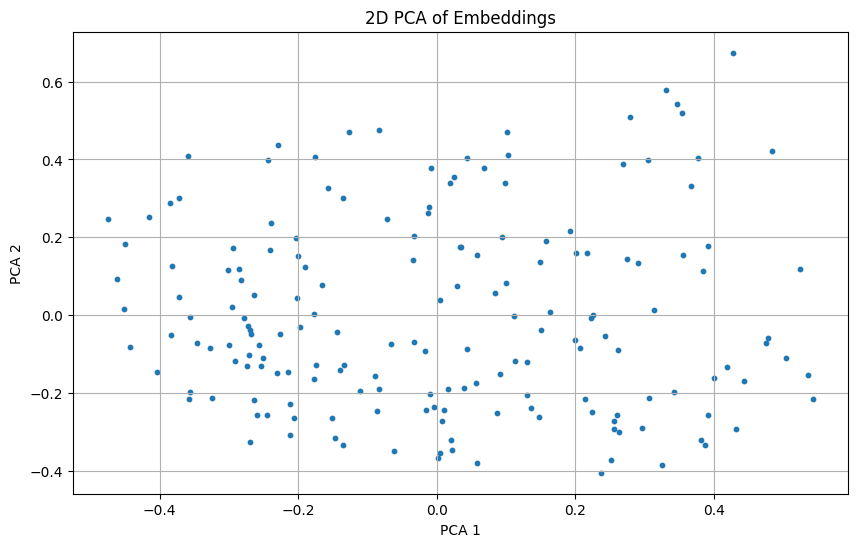

In [60]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=10)
plt.title("2D PCA of Embeddings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
generator = pipeline("text2text-generation", model="google/flan-t5-large")
def get_answer(query, model, index, chunks, top_k=5):
    query_embedding = model.encode([query])
    D, I = index.search(np.array(query_embedding), k=top_k)
    retrieved_docs = [chunks[i].page_content for i in I[0]]
    sns.barplot(x=list(range(1, top_k + 1)), y=D[0])
    plt.title("Similarity (L2 Distance) of Top Retrieved Chunks")
    plt.xlabel("Chunk Rank")
    plt.ylabel("L2 Distance")
    plt.show()
    context = "\n".join(retrieved_docs)
    prompt = f"Context:\n{context}\n\nQuestion: {query}\nAnswer:"
    answer = generator(prompt)[0]["generated_text"]
    print("Question:", query)
    print("Answer:", answer)

Device set to use cpu


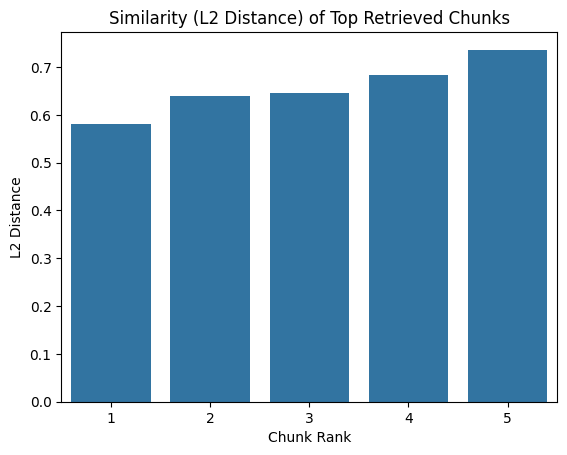

Token indices sequence length is longer than the specified maximum sequence length for this model (796 > 512). Running this sequence through the model will result in indexing errors


Question: What is AWS Lambda used for?
Answer: For compute processing tasks


In [68]:
get_answer("What is AWS Lambda used for?", model, index, chunks)

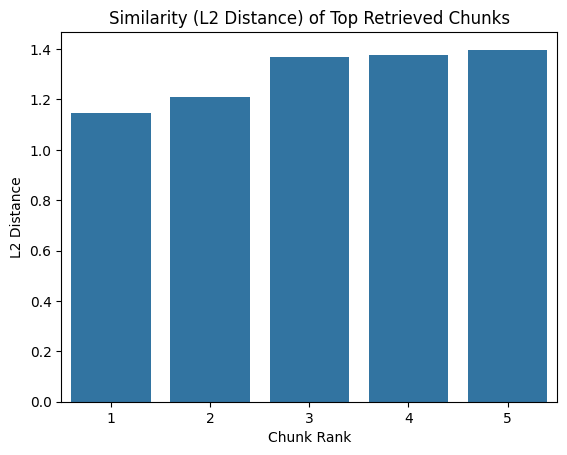

Question:  what is Regions
Answer: Every solution you build that runs in the AWS cloud will be deployed to at least one region.


In [69]:
get_answer(" what is Regions", model, index, chunks)

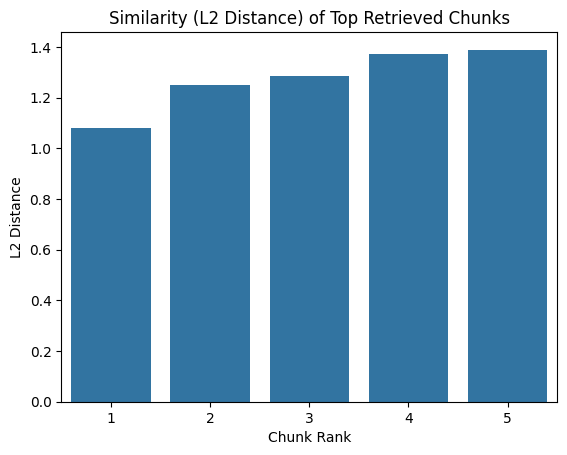

Question: what is Cloud9
Answer: AWS Cloud9


In [70]:
get_answer("what is Cloud9", model, index, chunks)

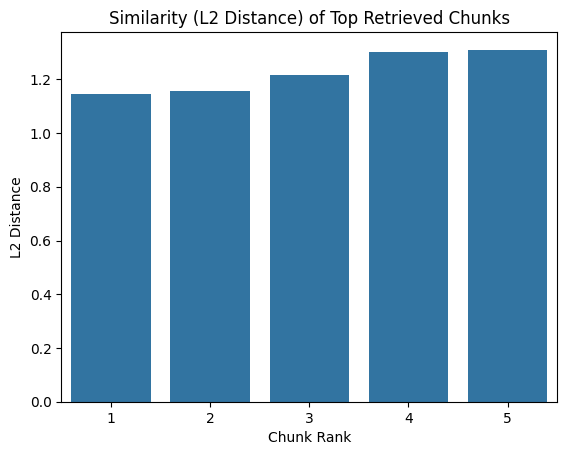

Question: describe How policies are evaluated
Answer: Statement field consists of one or many JSON objects that contain the specific Action, Effect, Resource


In [71]:
get_answer("describe How policies are evaluated", model, index, chunks)

In [65]:
from transformers import pipeline
import numpy as np

generator = pipeline("text2text-generation", model="google/flan-t5-xxl")

def ask_question(query, model, index, chunks, top_k=3):
    query_embedding = model.encode([query])
    D, I = index.search(np.array(query_embedding), k=top_k)
    retrieved_docs = [chunks[i].page_content for i in I[0]]

    context = "\n".join(retrieved_docs)
    prompt = f"Context:\n{context}\n\nQuestion: {query}\nAnswer:"

    answer = generator(
        prompt,
        max_length=2028,
        do_sample=False,         # deterministic
        temperature=0.0          # factual
    )[0]["generated_text"]

    print(f"\nQUESTION:\n{query}\n\nANSWER:\n{answer}\n")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Device set to use cpu


In [66]:
ask_question("describe How policies are evaluated", model, index, chunks)

Token indices sequence length is longer than the specified maximum sequence length for this model (605 > 512). Running this sequence through the model will result in indexing errors


KeyboardInterrupt: 